################################################################################

**Author**: _Pradip Kumar Das_

**License:** https://github.com/PradipKumarDas/Competitions/blob/main/LICENSE

**Profile & Contact:** [LinkedIn](https://www.linkedin.com/in/daspradipkumar/) | [GitHub](https://github.com/PradipKumarDas) | [Kaggle](https://www.kaggle.com/pradipkumardas) | pradipkumardas@hotmail.com (Email)

################################################################################

# **CommonLit Readability Assessment**
## Determinining Performance with BERT

**_Sections:_**
- _Required Packages & Helpers_
- _Configuration_
- _Data Preparation_
- _Modeling_
- _Evaluation_
- _Submission_

**_References (My Earlier Related Work):_**
1. [*Exploratory Data Analysis (EDA)*](https://www.kaggle.com/pradipkumardas/1-commonlit-readability-eda)
2. [*Baselining Model Performance with 1D ConvNet*](https://www.kaggle.com/pradipkumardas/2-commonlit-readability-baseline-perf-1dconvnet)

_**Note:** This notebook just fine-tunes pretrained BERT (base, uncased) model without cross validation, and tries to get the initial prediction performance. Other advanced options and techniques are being explored and will be shared soon._

## Required Packages & Helpers

In [1]:
# Imports required packages

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from transformers import TFAutoModelForSequenceClassification, AutoTokenizer

import matplotlib.pyplot as plt
import seaborn as sns

## Configurations

In [2]:
# Sets data configurations

data_config ={
    "n_bins": 20,
    "n_splits": 5    
}

In [3]:
# Sets model specific configurations

model_config = {
    "model_name": "../input/huggingface-bert/bert-base-cased",
    "model_path": "model.h5",
    "num_labels": 1,
    "learning_rate": 5e-5,
    "batch_size": 32,
    "max_length": 256,
    "steps_per_epoch": 70,  # ~(<validation size>/<batch size>)
    "epochs": 30,
}

In [4]:
# Setting initialization for the theme of the plots

sns.set_theme()

## Data Preparation

In [5]:
# Loads data

train = pd.read_csv("../input/commonlitreadabilityprize/train.csv")
test = pd.read_csv("../input/commonlitreadabilityprize/test.csv")
submission = pd.read_csv("../input/commonlitreadabilityprize/sample_submission.csv")

In [6]:
# Making all excerpts in lowercase

train.excerpt = train.excerpt.str.lower()

**Segmenting Labels (Distributing Lables in Discrete Intervals)**: As target is a interval variable, these labels should be segmented so that nearly equal number of samples from each segment can be selected during training model.

In [7]:
# Segments discrete interval of label by marking each sample with a bin number

train["bin"] = pd.cut(
    x=train.target, bins=data_config["n_bins"], 
    labels=[i for i in range(data_config["n_bins"])])

In [8]:
x_train, x_val, y_train, y_val = train_test_split(train.excerpt, train.target, test_size=0.2, shuffle=True, stratify=train.bin)

## Modeling

### Prepares Data for model training

In [9]:
# Creates tokenizer to prepare data for model training

tokenizer = AutoTokenizer.from_pretrained(model_config["model_name"])

In [10]:
# Encodes all training, validation and test data

train_encodings = tokenizer(
    x_train.tolist(), 
    max_length=model_config["max_length"], 
    truncation=True, 
    padding="max_length",
    return_tensors="tf")

val_encodings = tokenizer(
    x_val.tolist(), 
    max_length=model_config["max_length"], 
    truncation=True, 
    padding="max_length",
    return_tensors="tf")

test_encodings = tokenizer(
    test.excerpt.tolist(), 
    max_length=model_config["max_length"], 
    truncation=True, 
    padding="max_length",
    return_tensors="tf")

In [11]:
# Prepares training, validation and test data in a form (from encodings to dataset) the model expects to get trained on

train_dataset = tf.data.Dataset.from_tensor_slices((
    {"input_ids": train_encodings["input_ids"], "attention_mask": train_encodings["attention_mask"]},
    y_train))
train_dataset = train_dataset.repeat()
train_dataset = train_dataset.shuffle(1024)
train_dataset = train_dataset.batch(model_config["batch_size"])
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((
    {"input_ids": val_encodings["input_ids"], "attention_mask": val_encodings["attention_mask"]},
    y_val))
val_dataset = val_dataset.batch(model_config["batch_size"])
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices(
    {"input_ids": test_encodings["input_ids"], "attention_mask": test_encodings["attention_mask"]})
test_dataset = test_dataset.batch(model_config["batch_size"])
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

### Creates Model

In [12]:
# Creates primary model
encoder = TFAutoModelForSequenceClassification.from_pretrained(
    model_config["model_name"], num_labels = model_config["num_labels"])

# Creates multi inputs for model
input_ids = layers.Input(shape=(model_config["max_length"], ), dtype=tf.int32, name="input_ids")
attention_mask = layers.Input(shape=(model_config["max_length"]), dtype=tf.int32, name="attention_mask")

# Sets model output
outputs = encoder({"input_ids": input_ids, "attention_mask": attention_mask})

# Creates a wrapper model
model = Model(inputs=[input_ids, attention_mask], outputs=outputs)

# Compiles and shows the summary to check
model.compile(
    optimizer=keras.optimizers.Adam(model_config["learning_rate"]),
    loss=keras.losses.MeanSquaredError(),
    metrics=keras.metrics.RootMeanSquaredError())

model.summary()

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at ../input/huggingface-bert/bert-base-cased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
attention_mask (InputLayer)     [(None, 256)]        0                                            
__________________________________________________________________________________________________
input_ids (InputLayer)          [(None, 256)]        0                                            
__________________________________________________________________________________________________
tf_bert_for_sequence_classifica TFSequenceClassifier 108311041   attention_mask[0][0]             
                                                                 input_ids[0][0]                  
Total params: 108,311,041
Trainable params: 108,311,041
Non-trainable params: 0
__________________________________________________________________________________________________


### Sets Model Rules and Trains

In [13]:
# Configures monitor with rules for model training to stop if criterion match

early_stopping_monitor = EarlyStopping(
    monitor="val_root_mean_squared_error", mode="min", patience=5, restore_best_weights=True, verbose=1)

# Configures rules to store model parameters (only weights) at its best during training

checkpoint = ModelCheckpoint(
    model_config["model_path"], monitor="val_root_mean_squared_error", mode="min", save_best_only=True, save_weights_only=True)

# Fits (trains) the model

history = model.fit(
    x=train_dataset,
    validation_data=val_dataset,
    steps_per_epoch=model_config["steps_per_epoch"],
    callbacks=[early_stopping_monitor, checkpoint],
    epochs=model_config["epochs"],
    verbose=2).history

Epoch 1/30
70/70 - 87s - loss: 0.5574 - root_mean_squared_error: 0.7466 - val_loss: 0.4851 - val_root_mean_squared_error: 0.6965
Epoch 2/30
70/70 - 71s - loss: 0.2876 - root_mean_squared_error: 0.5363 - val_loss: 0.3085 - val_root_mean_squared_error: 0.5554
Epoch 3/30
70/70 - 71s - loss: 0.1710 - root_mean_squared_error: 0.4136 - val_loss: 0.3795 - val_root_mean_squared_error: 0.6161
Epoch 4/30
70/70 - 71s - loss: 0.0953 - root_mean_squared_error: 0.3088 - val_loss: 0.4398 - val_root_mean_squared_error: 0.6632
Epoch 5/30
70/70 - 71s - loss: 0.0611 - root_mean_squared_error: 0.2473 - val_loss: 0.3798 - val_root_mean_squared_error: 0.6163
Epoch 6/30
70/70 - 71s - loss: 0.0474 - root_mean_squared_error: 0.2177 - val_loss: 0.3542 - val_root_mean_squared_error: 0.5952
Epoch 7/30
70/70 - 71s - loss: 0.0420 - root_mean_squared_error: 0.2048 - val_loss: 0.2906 - val_root_mean_squared_error: 0.5391
Epoch 8/30
70/70 - 71s - loss: 0.0444 - root_mean_squared_error: 0.2108 - val_loss: 0.3870 - val_

## Evaluating Model 

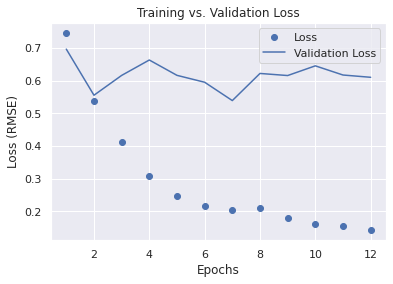

In [14]:
plt.title("Training vs. Validation Loss")
plt.plot(range(1, len(history["root_mean_squared_error"]) + 1), history["root_mean_squared_error"], "bo", label="Loss")
plt.plot(range(1, len(history["val_root_mean_squared_error"]) + 1), history["val_root_mean_squared_error"], "b", label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss (RMSE)")
plt.legend()
plt.show()

In [15]:
best_epoch = np.argmin(history["val_root_mean_squared_error"])
print(f"Best Validation Performance: {history['val_root_mean_squared_error'][best_epoch]} (RMSE) at epoch {best_epoch + 1}")

Best Validation Performance: 0.5390864014625549 (RMSE) at epoch 7


## Submission

In [16]:
# Predicts on test data

test_predictions = model.predict(test_dataset)["logits"]

In [17]:
# Averaging predictions across folds

submission.target = test_predictions

In [18]:
# Submitting by saving predictions into submission file

submission.to_csv("submission.csv", index=False)